In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import pickle as pkl

#### Vamos a usar el DataFrame undersampled y vamos a deshacernos de los outliers para mejorar los resultados

In [93]:
df_undersampled = pd.read_csv('../data/processed_data/df_undersample.csv')

# Detectar outliers usando el método IQR
Q1 = df_undersampled.quantile(0.25)
Q3 = df_undersampled.quantile(0.75)
IQR = Q3 - Q1

# Eliminar outliers
df_no_outliers = df_undersampled[~((df_undersampled < (Q1 - 1.5 * IQR)) |(df_undersampled > (Q3 + 1.5 * IQR))).any(axis=1)]

# Separar características y etiquetas
X_no_outliers = df_no_outliers.drop('Phishing', axis=1)
y_no_outliers = df_no_outliers['Phishing']

# Shuffle manualmente y dividir en train y test
df_no_outliers_shuffled = df_no_outliers.sample(frac=1, random_state=42).reset_index(drop=True)
train_size_no_outliers = int(0.8 * len(df_no_outliers_shuffled))
df_train_no_outliers = df_no_outliers_shuffled[:train_size_no_outliers]
df_test_no_outliers = df_no_outliers_shuffled[train_size_no_outliers:]

X_train_no_outliers = df_train_no_outliers.drop('Phishing', axis=1)
y_train_no_outliers = df_train_no_outliers['Phishing']
X_test_no_outliers = df_test_no_outliers.drop('Phishing', axis=1)
y_test_no_outliers = df_test_no_outliers['Phishing']

In [94]:
df_undersampled.columns

Index(['NumDots', 'UrlLength', 'NumDash', 'AtSymbol', 'IpAddress',
       'HttpsHostname', 'PathLength', 'NumChars', 'Phishing'],
      dtype='object')

#### 1.1 Supervisado: Logistic Regresion

In [112]:
# Separar características y etiquetas
X_train = df_undersampled.drop('Phishing', axis=1)
y_train = df_undersampled['Phishing']
X_test = df_undersampled.drop('Phishing', axis=1)
y_test = df_undersampled['Phishing']

In [104]:
# Entrenar el modelo
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [105]:
# Hacer predicciones
y_pred_log_reg = log_reg.predict(X_test)

In [106]:
# Evaluar el modelo
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg)}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg)}")
print(f"F1 Score: {f1_score(y_test, y_pred_log_reg)}")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression:
Accuracy: 0.6929581101142451
Precision: 0.6876887637573585
Recall: 0.797412002136879
F1 Score: 0.7384970589852125
              precision    recall  f1-score   support

           0       0.70      0.57      0.63     14139
           1       0.69      0.80      0.74     16847

    accuracy                           0.69     30986
   macro avg       0.69      0.68      0.68     30986
weighted avg       0.69      0.69      0.69     30986



In [37]:
# Guardar modelo en pkl
with open("../models/supervised/log_reg.pkl", "wb") as file:
    pkl.dump(log_reg, file)

#### 1.2 Supervisado: Random Forest

In [111]:
# Entrenar el modelo
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [113]:
# Hacer predicciones
y_pred_rf = rf_clf.predict(X_test)

In [114]:
# Evaluar el modelo
print("Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Random Forest:
Accuracy: 0.8435772065072842
Precision: 0.8220233353638536
Recall: 0.8770435252122266
F1 Score: 0.8486425820933068
              precision    recall  f1-score   support

           0       0.87      0.81      0.84    100011
           1       0.82      0.88      0.85    100011

    accuracy                           0.84    200022
   macro avg       0.85      0.84      0.84    200022
weighted avg       0.85      0.84      0.84    200022



In [102]:
# Guardar modelo en pkl
with open("../models/supervised/rfc_und.pkl", "wb") as file:
    pkl.dump(rf_clf, file)

#### 2.1 No Supervisado: K-Means

In [16]:
# Entrenar el modelo
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=2, random_state=42)

In [17]:
# Hacer predicciones
y_pred_kmeans = kmeans.predict(X_test)

In [18]:
# Convertir las etiquetas predichas a la misma escala que las etiquetas verdaderas
y_pred_kmeans = [1 if label == kmeans.cluster_centers_[1][0] > kmeans.cluster_centers_[0][0] else 0 for label in y_pred_kmeans]

In [21]:
# Evaluar el modelo
print("KMeans:")
print(confusion_matrix(y_test, y_pred_kmeans))
print(f"Accuracy: {accuracy_score(y_test, y_pred_kmeans)}")
print(f"Precision: {precision_score(y_test, y_pred_kmeans)}")
print(f"Recall: {recall_score(y_test, y_pred_kmeans)}")
print(f"F1 Score: {f1_score(y_test, y_pred_kmeans)}")
print(classification_report(y_test, y_pred_kmeans))

KMeans:
[[20026     0]
 [19979     0]]
Accuracy: 0.5005874265716785
Precision: 0.0


C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.0
F1 Score: 0.0
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     20026
           1       0.00      0.00      0.00     19979

    accuracy                           0.50     40005
   macro avg       0.25      0.50      0.33     40005
weighted avg       0.25      0.50      0.33     40005



C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
# Guardar modelo en pkl
with open("../models/unsupervised/kmeans.pkl", "wb") as file:
    pkl.dump(kmeans, file)

#### 2.2 No Supervisado: Isolation Forest

In [22]:
# Entrenar el modelo
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)

IsolationForest(random_state=42)

In [23]:
# Hacer predicciones
y_pred_iso_forest = iso_forest.predict(X_test)

In [24]:
# Convertir las etiquetas predichas (1 -> -1 y -1 -> 1)
y_pred_iso_forest = [0 if x == 1 else 1 for x in y_pred_iso_forest]

In [25]:
# Evaluar el modelo
print("Isolation Forest:")
print(confusion_matrix(y_test, y_pred_iso_forest))
print(f"Accuracy: {accuracy_score(y_test, y_pred_iso_forest)}")
print(f"Precision: {precision_score(y_test, y_pred_iso_forest)}")
print(f"Recall: {recall_score(y_test, y_pred_iso_forest)}")
print(f"F1 Score: {f1_score(y_test, y_pred_iso_forest)}")
print(classification_report(y_test, y_pred_iso_forest))

Isolation Forest:
[[17905  2121]
 [17595  2384]]
Accuracy: 0.5071616047994001
Precision: 0.5291897891231965
Recall: 0.11932529155613394
F1 Score: 0.19473942166312694
              precision    recall  f1-score   support

           0       0.50      0.89      0.64     20026
           1       0.53      0.12      0.19     19979

    accuracy                           0.51     40005
   macro avg       0.52      0.51      0.42     40005
weighted avg       0.52      0.51      0.42     40005



In [40]:
# Guardar modelo en pkl
with open("../models/unsupervised/iso_forest.pkl", "wb") as file:
    pkl.dump(iso_forest, file)

#### 3 Deep Learning:

In [28]:
# Definir el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6734 - loss: 0.6229 - val_accuracy: 0.7218 - val_loss: 0.5471
Epoch 2/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7397 - loss: 0.5268 - val_accuracy: 0.7492 - val_loss: 0.5032
Epoch 3/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7497 - loss: 0.5068 - val_accuracy: 0.7487 - val_loss: 0.5025
Epoch 4/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7583 - loss: 0.4954 - val_accuracy: 0.7476 - val_loss: 0.4973
Epoch 5/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7665 - loss: 0.4824 - val_accuracy: 0.7639 - val_loss: 0.4854
Epoch 6/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7703 - loss: 0.4765 - val_accuracy: 0.7731 - val_loss: 0.4727
Epoch 7/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7715 - loss: 0.4739 - val_accuracy: 0.7697 - val_loss: 0.4690
Epoch 8/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7765 - loss: 0

In [42]:
# Guardar el modelo
model.save('../models/deep_learning_model.keras')

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout

In [115]:
# Definir el modelo con más capas y dropout para prevenir sobreajuste
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo con una tasa de aprendizaje ajustada
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('deep_learning_model.keras', monitor='accuracy', save_best_only=True)

# Entrenar el modelo
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5975 - loss: 0.9224 - val_accuracy: 0.3017 - val_loss: 0.8352
Epoch 2/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.6756 - loss: 0.5764 - val_accuracy: 0.6341 - val_loss: 0.8303
Epoch 3/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.6988 - loss: 0.5573 - val_accuracy: 0.6480 - val_loss: 0.9430
Epoch 4/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7216 - loss: 0.5426 - val_accuracy: 0.4920 - val_loss: 0.9500
Epoch 5/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7446 - loss: 0.5186 - val_accuracy: 0.4295 - val_loss: 0.9363
Epoch 6/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.7489 - loss: 0.5070 - val_accuracy: 0.6181 - val_loss: 0.8944
Epoch 7/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.7541 - loss: 0.4984 - val_accuracy: 0.4070 - val_loss: 0.9476
Epoch 8/50
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.7557 - loss: 0

In [45]:
# Evaluar el modelo guardado
y_pred_dl = (model.predict(X_test) > 0.5).astype("int32")

# Evaluar el modelo
print("Deep Learning Improved Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dl)}")
print(f"Precision: {precision_score(y_test, y_pred_dl)}")
print(f"Recall: {recall_score(y_test, y_pred_dl)}")
print(f"F1 Score: {f1_score(y_test, y_pred_dl)}")
print(classification_report(y_test, y_pred_dl))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_dl)}")

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Deep Learning Improved Model:
Accuracy: 0.7496812898387701
Precision: 0.699883660288041
Recall: 0.8732168777216077
F1 Score: 0.7770008462120874
              precision    recall  f1-score   support

           0       0.83      0.63      0.71     20026
           1       0.70      0.87      0.78     19979

    accuracy                           0.75     40005
   macro avg       0.77      0.75      0.75     40005
weighted avg       0.77      0.75      0.75     40005

ROC AUC: 0.7498262556989144


In [51]:
# Guardar el modelo
model.save('../models/dl_2.keras')

In [54]:
# Definir el modelo con más capas y dropout para prevenir sobreajuste
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_no_outliers.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo con una tasa de aprendizaje ajustada
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('deep_learning_model.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(X_train_no_outliers, y_train_no_outliers,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3099/3099 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5417 - loss: 0.9356 - val_accuracy: 0.6595 - val_loss: 0.6209
Epoch 2/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6630 - loss: 0.6119 - val_accuracy: 0.7037 - val_loss: 0.5567
Epoch 3/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6953 - loss: 0.5787 - val_accuracy: 0.7057 - val_loss: 0.5510
Epoch 4/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6980 - loss: 0.5732 - val_accuracy: 0.7071 - val_loss: 0.5541
Epoch 5/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6979 - loss: 0.5710 - val_accuracy: 0.7196 - val_loss: 0.5432
Epoch 6/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7053 - loss: 0.5674 - val_accuracy: 0.7180 - val_loss: 0.5375
Epoch 7/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7059 - loss: 0.5664 - val_accuracy: 0.7189 - val_loss: 0.5433
Epoch 8/50
3099/3099 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7127 - loss: 0.5604 - val

In [55]:
# Evaluar el mejor modelo guardado
# best_model_no_outliers = tf.keras.models.load_model('best_model_no_outliers.h5')
y_pred_dl_no_outliers = (model.predict(X_test_no_outliers) > 0.5).astype("int32")

969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [56]:
# Evaluar el modelo
print("Deep Learning Improved Model without Outliers:")
print(f"Accuracy: {accuracy_score(y_test_no_outliers, y_pred_dl_no_outliers)}")
print(f"Precision: {precision_score(y_test_no_outliers, y_pred_dl_no_outliers)}")
print(f"Recall: {recall_score(y_test_no_outliers, y_pred_dl_no_outliers)}")
print(f"F1 Score: {f1_score(y_test_no_outliers, y_pred_dl_no_outliers)}")
print(classification_report(y_test_no_outliers, y_pred_dl_no_outliers))
print(f"ROC AUC: {roc_auc_score(y_test_no_outliers, y_pred_dl_no_outliers)}")

Deep Learning Improved Model without Outliers:
Accuracy: 0.7188730394371652
Precision: 0.750246062992126
Recall: 0.7239271086840388
F1 Score: 0.7368516448660243
              precision    recall  f1-score   support

           0       0.68      0.71      0.70     14139
           1       0.75      0.72      0.74     16847

    accuracy                           0.72     30986
   macro avg       0.72      0.72      0.72     30986
weighted avg       0.72      0.72      0.72     30986

ROC AUC: 0.7183890441220604


#### Como se esperaba, el mejor resultado se ha obtenido usando Random Forest Classifier. Avanzaré con ese modelo para ver si logro mejorarlo

##### GridSearch:

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [60]:
# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [82]:
# Crear el modelo
rf_clf = RandomForestClassifier(random_state=42)

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1, scoring='f1')

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_train_no_outliers, y_train_no_outliers)

Fitting 2 folds for each of 324 candidates, totalling 648 fits


KeyboardInterrupt: 

In [62]:
# Mejor conjunto de hiperparámetros
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Mejor modelo encontrado por GridSearchCV
best_rf_clf = grid_search.best_estimator_

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [63]:
# Hacer predicciones y evaluar el mejor modelo
y_pred_best_rf = best_rf_clf.predict(X_test_no_outliers)

print("Random Forest Classifier with GridSearchCV:")
print(f"Accuracy: {accuracy_score(y_test_no_outliers, y_pred_best_rf)}")
print(f"Precision: {precision_score(y_test_no_outliers, y_pred_best_rf)}")
print(f"Recall: {recall_score(y_test_no_outliers, y_pred_best_rf)}")
print(f"F1 Score: {f1_score(y_test_no_outliers, y_pred_best_rf)}")
print(classification_report(y_test_no_outliers, y_pred_best_rf))

Random Forest Classifier with GridSearchCV:
Accuracy: 0.7697669915445685
Precision: 0.7658619368259704
Recall: 0.8304149106665876
F1 Score: 0.7968331719542063
              precision    recall  f1-score   support

           0       0.78      0.70      0.73     14139
           1       0.77      0.83      0.80     16847

    accuracy                           0.77     30986
   macro avg       0.77      0.76      0.77     30986
weighted avg       0.77      0.77      0.77     30986



##### Pipelines:

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [65]:
# Crear el pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Configurar la búsqueda de hiperparámetros del pipeline
param_grid_pipeline = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

In [68]:
# Realizar la búsqueda de hiperparámetros
grid_search_pipeline = GridSearchCV(pipeline, param_grid=param_grid_pipeline, cv=2, n_jobs=-1, scoring='f1')
grid_search_pipeline.fit(X_train_no_outliers, y_train_no_outliers)

# Mejor conjunto de hiperparámetros
best_params_pipeline = grid_search_pipeline.best_params_
print(f"Best parameters from pipeline: {best_params_pipeline}")

C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
190 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

Best parameters from pipeline: {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}


In [71]:
# Mejor modelo encontrado por GridSearchCV
best_pipeline_rf_clf = grid_search_pipeline.best_estimator_

In [72]:
# Hacer predicciones y evaluar el mejor modelo del pipeline
y_pred_best_pipeline_rf = best_pipeline_rf_clf.predict(X_test_no_outliers)

print("Random Forest Classifier with GridSearchCV and Pipeline:")
print(f"Accuracy: {accuracy_score(y_test_no_outliers, y_pred_best_pipeline_rf)}")
print(f"Precision: {precision_score(y_test_no_outliers, y_pred_best_pipeline_rf)}")
print(f"Recall: {recall_score(y_test_no_outliers, y_pred_best_pipeline_rf)}")
print(f"F1 Score: {f1_score(y_test_no_outliers, y_pred_best_pipeline_rf)}")
print(classification_report(y_test_no_outliers, y_pred_best_pipeline_rf))

Random Forest Classifier with GridSearchCV and Pipeline:
Accuracy: 0.7702833537726715
Precision: 0.7661541828527658
Recall: 0.8311865614055916
F1 Score: 0.7973465436738413
              precision    recall  f1-score   support

           0       0.78      0.70      0.73     14139
           1       0.77      0.83      0.80     16847

    accuracy                           0.77     30986
   macro avg       0.77      0.76      0.77     30986
weighted avg       0.77      0.77      0.77     30986



In [77]:
# Guardar modelo en pkl
with open("../models/supervised/gs_pipe_best_est.pkl", "wb") as file:
    pkl.dump(grid_search_pipeline.best_estimator_, file)

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
def plot_confusion_matrix(y_test, y_pred):
 C = confusion_matrix(y_test, y_pred)
 A =(((C.T)/(C.sum(axis=1))).T)
 B =(C/C.sum(axis=0))
 plt.figure(figsize=(20,4))
 labels = [1,2]
 cmap=sns.light_palette("blue")
 plt.subplot(1, 3, 1)
 sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
 plt.ylabel('Original Class')
 plt.title("Confusion matrix")
 plt.subplot(1, 3, 2)
 sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
 plt.ylabel('Original Class')
 plt.title("Precision matrix")
 plt.subplot(1, 3, 3)
 sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
 plt.ylabel('Original Class')
 plt.title("Recall matrix")
 plt.show()

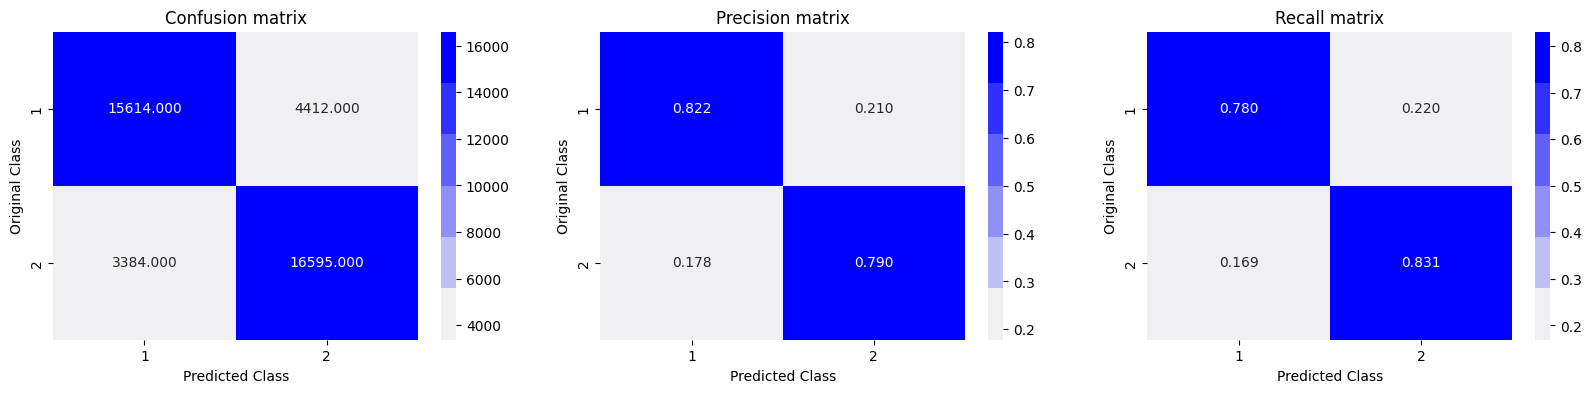

In [75]:
plot_confusion_matrix(y_test, y_pred_rf)
# Random Forest

In [86]:
# Importancia de las características
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

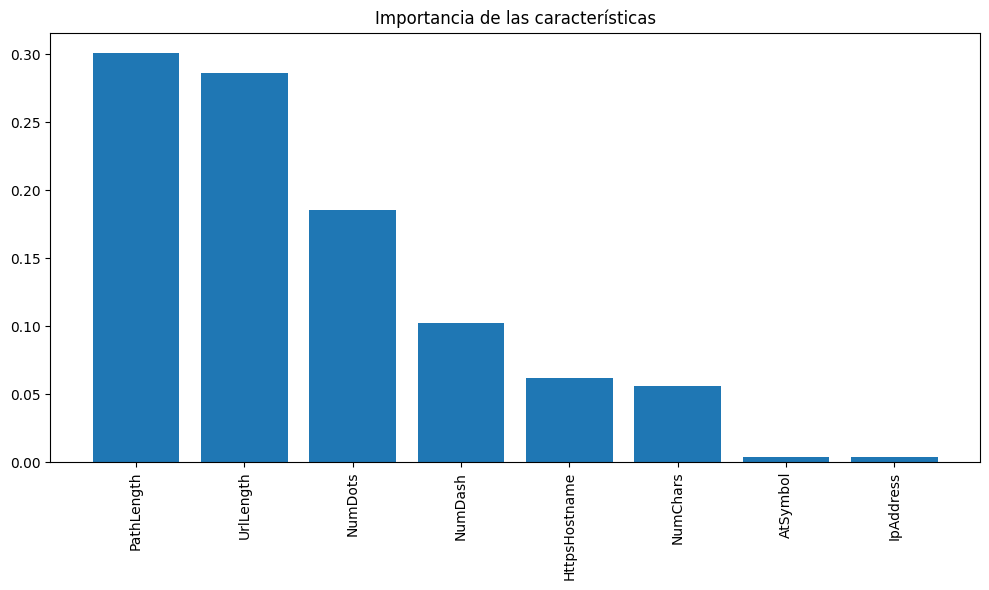

In [89]:
# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

#### Almacenar YAML

In [90]:
import yaml

config = {
    'model_type': 'RandomForestClassifier',
    'parameters': {
        'n_estimators': 'auto',
        'max_depth': None,
        'max_features': 'auto',
        'random_state': 42
    }
}

In [91]:
with open('../models/rfc_config.yml', 'w') as file:
    yaml.dump(config, file)